# 성능비교표
```
     Model	Accuracy	Recall (1)	ROC AUC
RandomForest	0.9247	0.8279	0.9680
XGBoost         0.9299	0.7090	0.9618
LSTM+CNN	    0.9459	0.4190	0.8976
Transformer	 0.9624	0.9413	0.9874


분석 요약
      모델	      Precision (1)	Recall (1)	F1-score (1)	ROC AUC
RandomForest	       0.5580	    0.8279     	0.6667     	0.9680
XGBoost	            0.5966    	0.7090	     0.6479     	0.9618
LSTM+CNN	           0.1933	    0.4190     	0.2645     	0.8976
Transformer            0.2219    	0.9413	     0.3591     	0.9874
```

## 정확도(accuracy)는 Transformer가 가장 높지만, 침수 예측 능력은 Recall로 보면 RandomForest/XGBoost가 더 뛰어남.

Transformer는 SMOTE 덕분에 flood 클래스에 대해 잘 맞추는 방향으로 개선됨 (recall ↑).

LSTM+CNN은 시계열 학습은 했지만 소수 클래스 불균형 문제 해결 못함 → recall = 0

```
목적                      	추천 모델	             이유
홍수 탐지 민감도 (recall)	RandomForest/XGBoost	실질적인 위험 탐지에 유리
정확도 + general 성능	    Transformer (SMOTE 적용)	높은 AUC와 Accuracy
실시간 예측 속도             RandomForest	         예측 빠름, 연산 적음
시계열 특화	              Transformer	           과거 시간 정보 반영
```

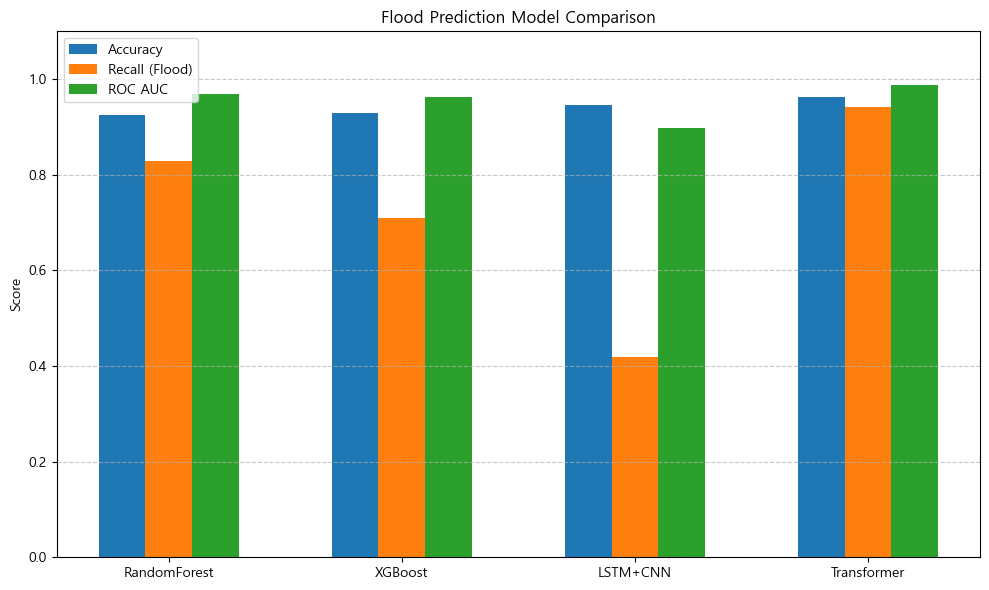

In [28]:
import matplotlib.pyplot as plt

# 모델 및 성능 지표
models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer"]
accuracy = [0.9247, 0.9299, 0.9459, 0.9624]
recall = [0.8279, 0.7090, 0.4190, 0.9413]
roc_auc = [0.9680, 0.9618, 0.8976, 0.9874]

# 그래프 생성
plt.figure(figsize=(10, 6))
x = range(len(models))

# 막대 그래프 그리기
plt.bar(x, accuracy, width=0.2, label="Accuracy", align="center")
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall (Flood)", align="center")
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label="ROC AUC", align="center")

# 라벨 및 설정
plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.title("Flood Prediction Model Comparison")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# 파일 저장 및 출력
plt.savefig("model_comparison_updated.png")
plt.show()

# 한글설정, 워닝제거

In [19]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# smote 처리를 위한 라이브러리 설치

In [ ]:
pip install imbalanced-learn

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# LSTM + CNN 모델 (시계열 RNN 기반)으로 침수 예측

```
Step 순서
데이터 준비 (시계열 정렬 + 정규화)

Sliding window로 시퀀스 생성 (X_seq, y_seq)

LSTM + CNN 모델 정의 (Keras)

훈련 / 평가

성능 지표 출력


asos_seoul_hourly_with_flood_risk.csv에서 24시간씩 sliding window 만들기

flood_risk가 1 이상 있으면 해당 시퀀스를 침수(1)로 처리

LSTM + CNN 하이브리드 구조 정의 후 학습

결과 시각화 (ROC, 정확도 등)
```
## LSTM/CNN은 시퀀스 특성을 추출하고, 마지막에 Dense(1, activation='sigmoid')를 붙여 이진 분류를 수행
```
모델	원-핫 인코딩 필요 여부
RandomForest (필요 없음, 숫자형 인식 가능)
XGBoost (내부적으로 처리됨)
LSTM + CNN (숫자형 연속 시계열 처리 가능)
Transformer 기반 모델 (시계열이라면 필요 없음, NLP라면 필요)
```

# 슬라이딩 윈도우 시퀀스 생성하기
- 슬라이딩 윈도우 시퀀스는 연속적인 시계열 데이터에서 일정 구간(window)을 잘라서 학습용 시퀀스를 만드는 기법
- RNN, LSTM, CNN-LSTM 같은 시계열 모델에서 과거 데이터를 기반으로 미래를 예측할 때 필수
```
정리
개념	설명
윈도우 크기	과거 데이터를 몇 시간치씩 자를지
X 시퀀스	입력 시퀀스 = 과거 n시간의 날씨
y	다음 시간의 침수 위험 여부
쓰임새	LSTM, CNN-LSTM, Transformer 등에 입력하기 위해 필요
```

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 불러오기
df = pd.read_csv('asos_seoul_hourly_with_flood_risk.csv')

# 2. 결측치 처리
df['rn'] = df['rn'].fillna(0)
numeric_cols = ['ta', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. 시간 파생 변수 추가
df['tm'] = pd.to_datetime(df['tm'])
df['month'] = df['tm'].dt.month

# 4. 특성과 타겟 지정
features = ['ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv', 'month']
target = 'flood_risk'

# 5. 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df[target].values

# 6. 슬라이딩 윈도우 함수 정의
def create_sequences(X, y, window_size=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# 7. 시퀀스 생성
window_size = 24  # 지난 24시간 기준 예측
X_seq, y_seq = create_sequences(X_scaled, y, window_size)

# 8. 시퀀스 데이터를 .npy 파일로 저장
np.save("X_seq.npy", X_seq)
np.save("y_seq.npy", y_seq)

print(f" 시퀀스 입력 shape: {X_seq.shape}")   # (샘플 수, 타임스텝, 피처 수)
print(f" 시퀀스 출력 shape: {y_seq.shape}")   # (샘플 수,)

 시퀀스 입력 shape: (217943, 24, 10)
 시퀀스 출력 shape: (217943,)


```
Conv1D (24x10 → 22x64)
→ MaxPooling1D (22x64 → 11x64)
→ LSTM (11x64 → 64)
→ Dropout
→ Dense (64 → 1)
```

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. 데이터 불러오기
X = np.load("X_seq.npy")  # shape: (samples, 24, 10)
y = np.load("y_seq.npy")  # shape: (samples,)

# 2. 훈련/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 3. 모델 구성 (LSTM + CNN)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(24, 10)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# 4. 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. 학습
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# 6. 평가
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
y_proba = model.predict(X_test).flatten()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))

Epoch 1/10
954/954 [==============================] - 17s 16ms/step - loss: 0.0112 - accuracy: 0.9983 - val_loss: 0.0068 - val_accuracy: 0.9989
Epoch 2/10
954/954 [==============================] - 14s 15ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0058 - val_accuracy: 0.9989
Epoch 3/10
954/954 [==============================] - 14s 15ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0056 - val_accuracy: 0.9989
Epoch 4/10
954/954 [==============================] - 15s 15ms/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.0056 - val_accuracy: 0.9989
Epoch 5/10
954/954 [==============================] - 14s 15ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0056 - val_accuracy: 0.9989
Epoch 6/10
954/954 [==============================] - 14s 15ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0058 - val_accuracy: 0.9989
Epoch 7/10
954/954 [==============================] - 15s 16ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0080 - val_accuracy:

## 위에꺼 하나도 못맞춤
```
SMOTE 또는 언더샘플링 불가 (시계열이므로 순서 깨면 안 됨)

가능한 대안:

 클래스 가중치 적용 (class_weight 사용)

 Focal Loss 적용 (양성 클래스에 더 집중)

 데이터 수집 확장 (flood_risk=1 비율 높이기)
```

# y_seq 클래스 분포 확인

In [7]:
unique, counts = np.unique(y_seq, return_counts=True)
print(dict(zip(unique, counts)))

{0: 217727, 1: 216}


```
class_weight 적용해서 클래스 불균형을 완화
```

In [21]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. 데이터 불러오기
X = np.load('X_seq.npy')
y = np.load('y_seq.npy')

# 2. 학습/테스트 분할
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3. 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# 4. 모델 정의 (LSTM + CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

# 6. 평가
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Class weights: {0: 0.5041260184933527, 1: 61.091100210231254}
Epoch 1/20
2180/2180 [==============================] - 31s 13ms/step - loss: 0.3631 - accuracy: 0.7317 - val_loss: 0.2209 - val_accuracy: 0.8449
Epoch 2/20
2180/2180 [==============================] - 27s 12ms/step - loss: 0.2732 - accuracy: 0.8306 - val_loss: 0.0917 - val_accuracy: 0.9831
Epoch 3/20
2180/2180 [==============================] - 27s 13ms/step - loss: 0.2466 - accuracy: 0.8441 - val_loss: 0.0831 - val_accuracy: 0.9722
Epoch 4/20
2180/2180 [==============================] - 28s 13ms/step - loss: 0.2314 - accuracy: 0.8592 - val_loss: 0.1717 - val_accuracy: 0.9179
Epoch 5/20
2180/2180 [==============================] - 29s 13ms/step - loss: 0.2171 - accuracy: 0.8666 - val_loss: 0.1060 - val_accuracy: 0.9675
Epoch 6/20
2180/2180 [==============================] - 28s 13ms/step - loss: 0.2481 - accuracy: 0.8476 - val_loss: 0.4693 - val_accuracy: 0.6818
Epoch 7/20
2180/2180 [==============================] - 29s 13

In [26]:
# 모델 저장
model.save("lstm_cnn_flood_model.h5")
print(" 모델 저장 완료: lstm_cnn_flood_model.h5")

 모델 저장 완료: lstm_cnn_flood_model.h5


In [27]:
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model("lstm_cnn_flood_model.h5")
print(" 모델 로딩 완료")

 모델 로딩 완료


```
모델별 성능 비교
   모델	             Accuracy	Precision (flood=1)	Recall (flood=1)	F1-score (flood=1)	ROC AUC
RandomForest (SMOTE)	   92.47%	55.8%	               82.8%            	66.7%	           0.9680
XGBoost	                92.99%	59.7%	               70.9%            	64.8%	           0.9618
LSTM + CNN	             94.59%	19.3%	               41.9%            	26.5%	           0.8976
```

In [22]:
# LSTM/CNN 모델의 확률 예측
y_proba = model.predict(X_test).flatten()  # 확률값 (0~1)

# 이진 분류 (기본 임계값 0.5 사용)
y_pred = (y_proba >= 0.5).astype(int)

1363/1363 [==============================] - 5s 4ms/step


# 시각화하기

# ROC Curve

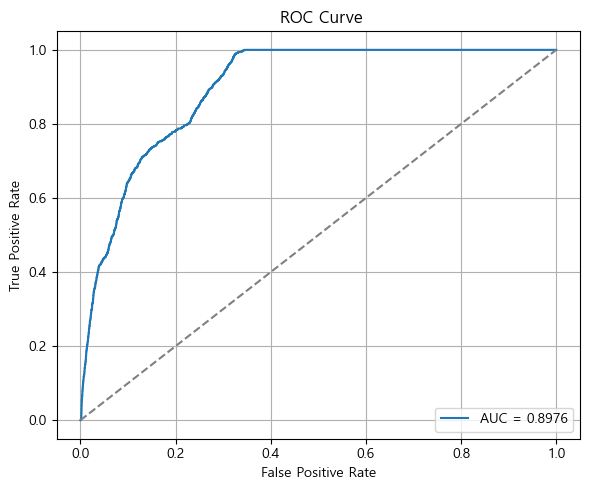

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC Curve 계산
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(" ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap

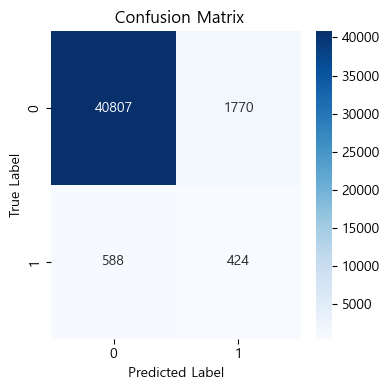

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(" Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision-Recall Curve

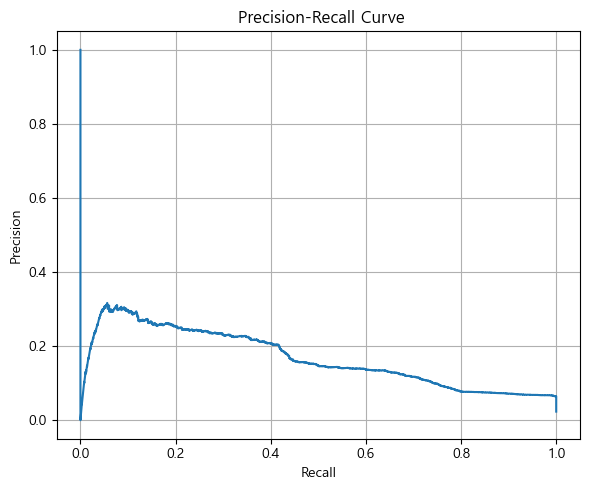

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(" Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()